In [1]:
import tensorflow as tf
import numpy as np
import math
import timeit
import matplotlib.pyplot as plt
%matplotlib inline

In [21]:
from cs231n.data_utils import load_CIFAR10

def get_CIFAR10_data(num_training=49000, num_validation=1000, num_test=10000):
    """
    Load the CIFAR-10 dataset from disk and perform preprocessing to prepare
    it for the two-layer neural net classifier. These are the same steps as
    we used for the SVM, but condensed to a single function.  
    """
    # Load the raw CIFAR-10 data
    cifar10_dir = 'cs231n/datasets/cifar-10-batches-py'
    X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)

    # Subsample the data
    mask = range(num_training, num_training + num_validation)
    X_val = X_train[mask]
    y_val = y_train[mask]
    mask = range(num_training)
    X_train = X_train[mask]
    y_train = y_train[mask]
    mask = range(num_test)
    X_test = X_test[mask]
    y_test = y_test[mask]

    # Normalize the data: subtract the mean image
    mean_image = np.mean(X_train, axis=0)
    X_train -= mean_image
    X_val -= mean_image
    X_test -= mean_image

    return X_train, y_train, X_val, y_val, X_test, y_test


# Invoke the above function to get our data.
X_train, y_train, X_val, y_val, X_test, y_test = get_CIFAR10_data()
print('Train data shape: ', X_train.shape)
print('Train labels shape: ', y_train.shape)
print('Validation data shape: ', X_val.shape)
print('Validation labels shape: ', y_val.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)

Train data shape:  (49000, 32, 32, 3)
Train labels shape:  (49000,)
Validation data shape:  (1000, 32, 32, 3)
Validation labels shape:  (1000,)
Test data shape:  (10000, 32, 32, 3)
Test labels shape:  (10000,)


In [3]:
xx_test = X_train[:1000]
yy_test = y_train[:1000]
print(xx_test.shape)
print(yy_test.shape)

(1000, 32, 32, 3)
(1000,)


In [4]:
def run_model(session, predict, loss_val, Xd, yd,
              epochs=1, batch_size=64, print_every=100,
              training=None, plot_losses=False):
    # have tensorflow compute accuracy
    correct_prediction = tf.equal(tf.argmax(predict,1), y)
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
    
    # shuffle indicies
    train_indicies = np.arange(Xd.shape[0])
    np.random.shuffle(train_indicies)

    training_now = training is not None
    
    # setting up variables we want to compute (and optimizing)
    # if we have a training function, add that to things we compute
    variables = [mean_loss,correct_prediction,accuracy]
    if training_now:
        variables[-1] = training
    
    # counter 
    iter_cnt = 0
    for e in range(epochs):
        # keep track of losses and accuracy
        correct = 0
        losses = []
        # make sure we iterate over the dataset once
        for i in range(int(math.ceil(Xd.shape[0]/batch_size))):
            # generate indicies for the batch
            start_idx = (i*batch_size)%Xd.shape[0]
            idx = train_indicies[start_idx:start_idx+batch_size]
            
            # create a feed dictionary for this batch
            feed_dict = {X: Xd[idx,:],
                         y: yd[idx],
                         is_training: training_now }
            # get batch size
            actual_batch_size = yd[idx].shape[0]
            
            # have tensorflow compute loss and correct predictions
            # and (if given) perform a training step
            loss, corr, _ = session.run(variables,feed_dict=feed_dict)
            
            # aggregate performance stats
            losses.append(loss*actual_batch_size)
            correct += np.sum(corr)
            
            # print every now and then
            if training_now and (iter_cnt % print_every) == 0:
                print("Iteration {0}: with minibatch training loss = {1:.3g} and accuracy of {2:.2g}"\
                      .format(iter_cnt,loss,np.sum(corr)/actual_batch_size))
            iter_cnt += 1
        total_correct = correct/Xd.shape[0]
        total_loss = np.sum(losses)/Xd.shape[0]
        print("Epoch {2}, Overall loss = {0:.3g} and accuracy of {1:.3g}"\
              .format(total_loss,total_correct,e+1))
        if plot_losses:
            plt.plot(losses)
            plt.grid(True)
            plt.title('Epoch {} Loss'.format(e+1))
            plt.xlabel('minibatch number')
            plt.ylabel('minibatch loss')
            plt.show()
    return total_loss,total_correct

In [13]:
tf.reset_default_graph()
def my_model(X,y,is_training):

    conv1 = tf.layers.conv2d(inputs=X, filters=32,kernel_size=[3, 3])
    bn1 = tf.layers.batch_normalization(conv1,training = is_training)
    relu1 = tf.nn.relu(bn1)
    conv2 = tf.layers.conv2d(inputs=relu1,filters=64,kernel_size=[3, 3])
    bn2 = tf.layers.batch_normalization(conv2,training = is_training)
    relu2 = tf.nn.relu(bn2)    
    pool1 = tf.layers.max_pooling2d(inputs=relu2, pool_size=[2, 2], strides=2)
    
    conv3 = tf.layers.conv2d(inputs=pool1, filters=128,kernel_size=[3, 3])
    bn3 = tf.layers.batch_normalization(conv3,training = is_training)
    relu3 = tf.nn.relu(bn3)
    conv4 = tf.layers.conv2d(inputs=relu3,filters=256,kernel_size=[3, 3])
    bn4 = tf.layers.batch_normalization(conv4,training = is_training)
    relu4 = tf.nn.relu(bn4)
    pool2 = tf.layers.max_pooling2d(inputs=relu4, pool_size=[2, 2], strides=2)
    
    input_affine = tf.reshape(pool2,[-1,5*5*256])
    dense1 = tf.layers.dense(inputs=input_affine, units=1024)
    bn5 = tf.layers.batch_normalization(dense1,training = is_training)
    relu5 = tf.nn.relu(bn5)
    dense2 = tf.layers.dense(inputs=relu5, units=10)
    return dense2

tf.reset_default_graph()

X = tf.placeholder(tf.float32, [None, 32, 32, 3])
y = tf.placeholder(tf.int64, [None])
is_training = tf.placeholder(tf.bool)

y_out = my_model(X,y,is_training)
total_loss=tf.nn.softmax_cross_entropy_with_logits(labels=tf.one_hot(y,10),logits=y_out)
mean_loss = tf.reduce_mean(total_loss)
optimizer = tf.train.RMSPropOptimizer(8e-4,decay=0.95,momentum=0.1)

pass

# batch normalization in tensorflow requires this extra dependency
extra_update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
with tf.control_dependencies(extra_update_ops):
    train_step = optimizer.minimize(mean_loss)

Training
Iteration 0: with minibatch training loss = 2.36 and accuracy of 0.12
Epoch 1, Overall loss = 2.44 and accuracy of 0.148


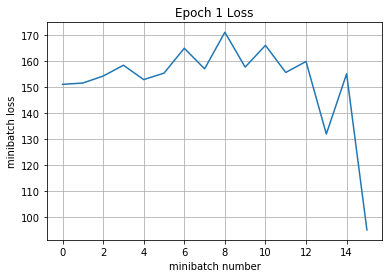

Epoch 2, Overall loss = 2.08 and accuracy of 0.243


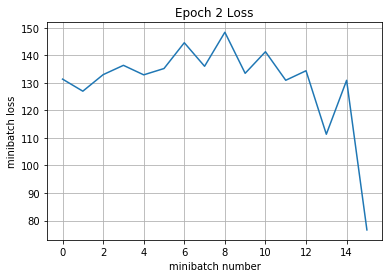

Epoch 3, Overall loss = 1.75 and accuracy of 0.388


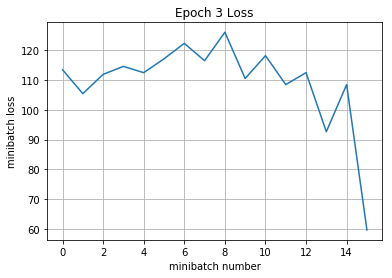

Epoch 4, Overall loss = 1.44 and accuracy of 0.525


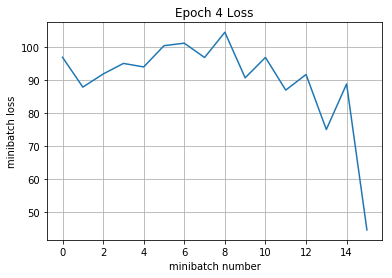

Epoch 5, Overall loss = 1.15 and accuracy of 0.687


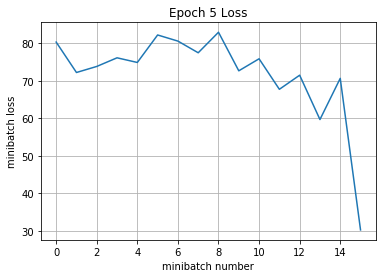

Epoch 6, Overall loss = 0.872 and accuracy of 0.819


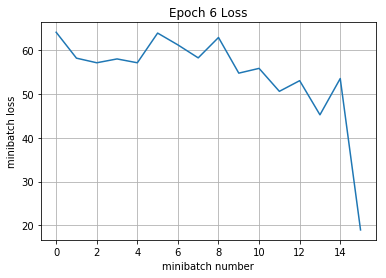

Iteration 100: with minibatch training loss = 0.633 and accuracy of 0.92
Epoch 7, Overall loss = 0.619 and accuracy of 0.929


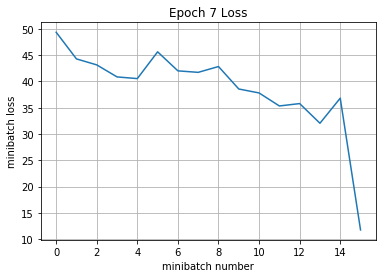

Epoch 8, Overall loss = 0.396 and accuracy of 0.977


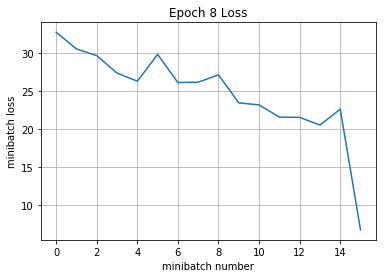

Epoch 9, Overall loss = 0.23 and accuracy of 0.998


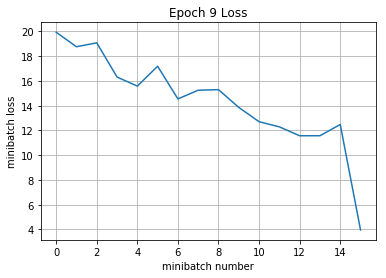

Epoch 10, Overall loss = 0.126 and accuracy of 1


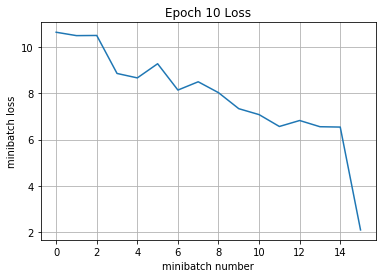

Validation
Epoch 1, Overall loss = 1.92 and accuracy of 0.3


(1.9168866968154907, 0.29999999999999999)

In [9]:
#small data to overfit
sess = tf.Session()
sess.run(tf.global_variables_initializer())
print('Training')
run_model(sess,y_out,mean_loss,xx_test,yy_test,10,64,100,train_step,True)
print('Validation')
run_model(sess,y_out,mean_loss,X_val,y_val,1,64)

In [12]:
sess.close()

Training
Iteration 0: with minibatch training loss = 2.59 and accuracy of 0.062
Iteration 100: with minibatch training loss = 1.73 and accuracy of 0.39
Iteration 200: with minibatch training loss = 1.81 and accuracy of 0.38
Iteration 300: with minibatch training loss = 1.19 and accuracy of 0.61
Iteration 400: with minibatch training loss = 1.19 and accuracy of 0.61
Iteration 500: with minibatch training loss = 0.965 and accuracy of 0.66
Iteration 600: with minibatch training loss = 1.36 and accuracy of 0.55
Iteration 700: with minibatch training loss = 0.927 and accuracy of 0.59
Epoch 1, Overall loss = 1.36 and accuracy of 0.526


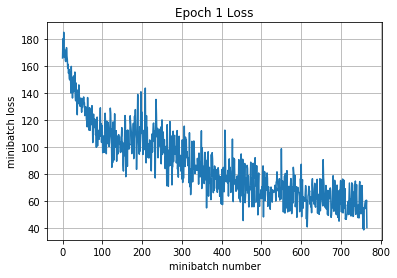

Iteration 800: with minibatch training loss = 1.03 and accuracy of 0.64
Iteration 900: with minibatch training loss = 0.804 and accuracy of 0.73
Iteration 1000: with minibatch training loss = 0.847 and accuracy of 0.73
Iteration 1100: with minibatch training loss = 0.701 and accuracy of 0.8
Iteration 1200: with minibatch training loss = 0.629 and accuracy of 0.75
Iteration 1300: with minibatch training loss = 0.736 and accuracy of 0.8
Iteration 1400: with minibatch training loss = 0.642 and accuracy of 0.77
Iteration 1500: with minibatch training loss = 0.656 and accuracy of 0.81
Epoch 2, Overall loss = 0.73 and accuracy of 0.745


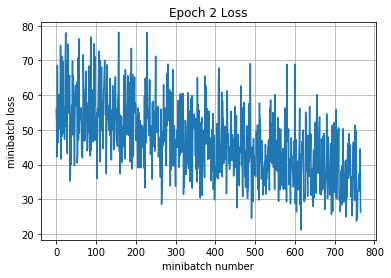

Iteration 1600: with minibatch training loss = 0.585 and accuracy of 0.8
Iteration 1700: with minibatch training loss = 0.431 and accuracy of 0.86
Iteration 1800: with minibatch training loss = 0.333 and accuracy of 0.88
Iteration 1900: with minibatch training loss = 0.357 and accuracy of 0.84
Iteration 2000: with minibatch training loss = 0.322 and accuracy of 0.89
Iteration 2100: with minibatch training loss = 0.434 and accuracy of 0.86
Iteration 2200: with minibatch training loss = 0.336 and accuracy of 0.91
Epoch 3, Overall loss = 0.467 and accuracy of 0.84


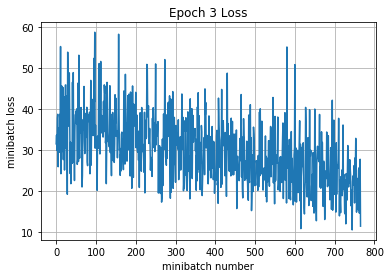

Iteration 2300: with minibatch training loss = 0.281 and accuracy of 0.92
Iteration 2400: with minibatch training loss = 0.316 and accuracy of 0.83
Iteration 2500: with minibatch training loss = 0.32 and accuracy of 0.92
Iteration 2600: with minibatch training loss = 0.203 and accuracy of 0.92
Iteration 2700: with minibatch training loss = 0.246 and accuracy of 0.92
Iteration 2800: with minibatch training loss = 0.153 and accuracy of 0.94
Iteration 2900: with minibatch training loss = 0.165 and accuracy of 0.98
Iteration 3000: with minibatch training loss = 0.284 and accuracy of 0.92
Epoch 4, Overall loss = 0.269 and accuracy of 0.912


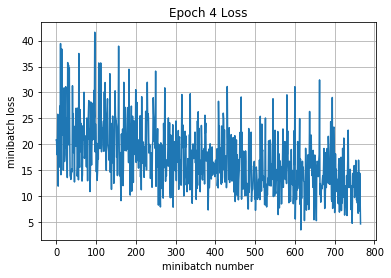

Iteration 3100: with minibatch training loss = 0.123 and accuracy of 0.97
Iteration 3200: with minibatch training loss = 0.108 and accuracy of 0.97
Iteration 3300: with minibatch training loss = 0.145 and accuracy of 0.98
Iteration 3400: with minibatch training loss = 0.0858 and accuracy of 0.97
Iteration 3500: with minibatch training loss = 0.105 and accuracy of 0.97
Iteration 3600: with minibatch training loss = 0.14 and accuracy of 0.95
Iteration 3700: with minibatch training loss = 0.238 and accuracy of 0.92
Iteration 3800: with minibatch training loss = 0.124 and accuracy of 0.94
Epoch 5, Overall loss = 0.148 and accuracy of 0.952


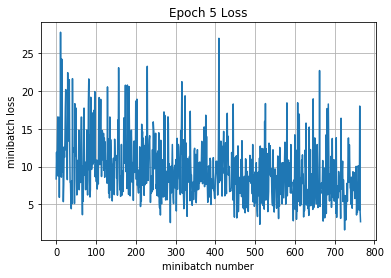

Iteration 3900: with minibatch training loss = 0.182 and accuracy of 0.89
Iteration 4000: with minibatch training loss = 0.0681 and accuracy of 0.97
Iteration 4100: with minibatch training loss = 0.0938 and accuracy of 0.97
Iteration 4200: with minibatch training loss = 0.158 and accuracy of 0.97
Iteration 4300: with minibatch training loss = 0.153 and accuracy of 0.94
Iteration 4400: with minibatch training loss = 0.116 and accuracy of 0.92
Iteration 4500: with minibatch training loss = 0.0261 and accuracy of 1
Epoch 6, Overall loss = 0.103 and accuracy of 0.966


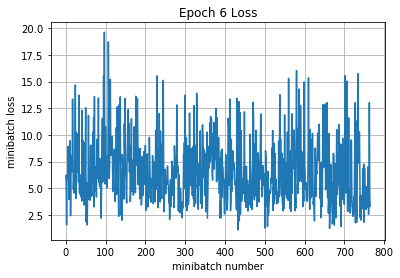

Iteration 4600: with minibatch training loss = 0.0824 and accuracy of 0.95
Iteration 4700: with minibatch training loss = 0.0513 and accuracy of 0.98
Iteration 4800: with minibatch training loss = 0.0469 and accuracy of 1
Iteration 4900: with minibatch training loss = 0.0227 and accuracy of 1
Iteration 5000: with minibatch training loss = 0.0479 and accuracy of 1
Iteration 5100: with minibatch training loss = 0.103 and accuracy of 0.95
Iteration 5200: with minibatch training loss = 0.0627 and accuracy of 0.97
Iteration 5300: with minibatch training loss = 0.0835 and accuracy of 0.98
Epoch 7, Overall loss = 0.0841 and accuracy of 0.971


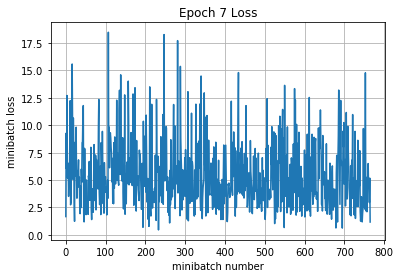

Iteration 5400: with minibatch training loss = 0.0258 and accuracy of 1
Iteration 5500: with minibatch training loss = 0.0281 and accuracy of 0.98
Iteration 5600: with minibatch training loss = 0.0662 and accuracy of 0.97
Iteration 5700: with minibatch training loss = 0.0473 and accuracy of 0.97
Iteration 5800: with minibatch training loss = 0.0292 and accuracy of 1
Iteration 5900: with minibatch training loss = 0.0249 and accuracy of 1
Iteration 6000: with minibatch training loss = 0.0715 and accuracy of 0.98
Iteration 6100: with minibatch training loss = 0.0617 and accuracy of 0.98
Epoch 8, Overall loss = 0.0659 and accuracy of 0.977


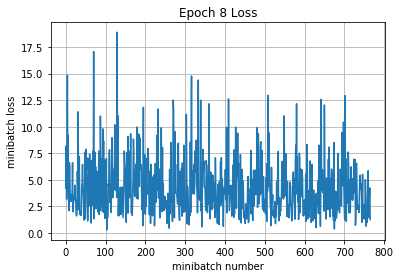

Iteration 6200: with minibatch training loss = 0.0674 and accuracy of 0.98
Iteration 6300: with minibatch training loss = 0.0833 and accuracy of 0.97
Iteration 6400: with minibatch training loss = 0.0616 and accuracy of 0.98
Iteration 6500: with minibatch training loss = 0.0691 and accuracy of 0.97
Iteration 6600: with minibatch training loss = 0.0334 and accuracy of 1
Iteration 6700: with minibatch training loss = 0.0438 and accuracy of 0.98
Iteration 6800: with minibatch training loss = 0.0588 and accuracy of 0.97
Epoch 9, Overall loss = 0.0549 and accuracy of 0.981


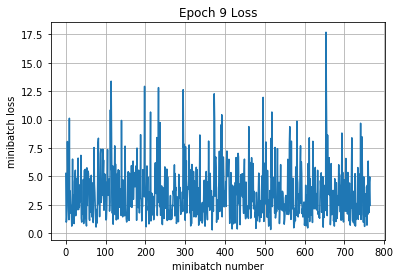

Iteration 6900: with minibatch training loss = 0.111 and accuracy of 0.95
Iteration 7000: with minibatch training loss = 0.0358 and accuracy of 0.98
Iteration 7100: with minibatch training loss = 0.0217 and accuracy of 1
Iteration 7200: with minibatch training loss = 0.032 and accuracy of 1
Iteration 7300: with minibatch training loss = 0.0301 and accuracy of 0.98
Iteration 7400: with minibatch training loss = 0.0118 and accuracy of 1
Iteration 7500: with minibatch training loss = 0.0567 and accuracy of 0.97
Iteration 7600: with minibatch training loss = 0.0277 and accuracy of 0.98
Epoch 10, Overall loss = 0.0466 and accuracy of 0.985


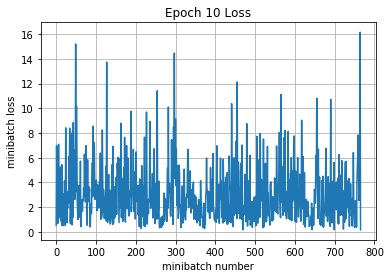

Validation
Epoch 1, Overall loss = 1.2 and accuracy of 0.786


(1.2025373106002808, 0.78600000000000003)

In [14]:
sess = tf.Session()

sess.run(tf.global_variables_initializer())
print('Training')
run_model(sess,y_out,mean_loss,X_train,y_train,10,64,100,train_step,True)
print('Validation')
run_model(sess,y_out,mean_loss,X_val,y_val,1,64)

In [24]:
print('Training')
run_model(sess,y_out,mean_loss,X_train,y_train,1,64)
print('Validation')
run_model(sess,y_out,mean_loss,X_val,y_val,1,64)

Training
Epoch 1, Overall loss = 0.185 and accuracy of 0.944
Validation
Epoch 1, Overall loss = 1.2 and accuracy of 0.786


(1.2025373363494873, 0.78600000000000003)

In [23]:
print('Test')
run_model(sess,y_out,mean_loss,X_test,y_test,1,64)

Test
Epoch 1, Overall loss = 1.28 and accuracy of 0.776


(1.2831359529495239, 0.77580000000000005)

In [22]:
y_test.shape

(10000,)